<AxesSubplot:ylabel='Frequency'>

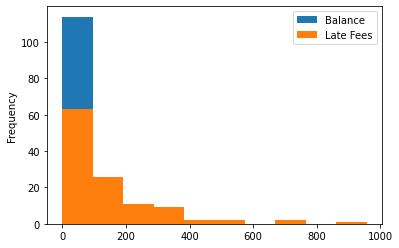

In [1]:
#  Generate a list of users with large late fees or very overdue items
#
# Fees are spread between late fees on items that are still checked out ("Loans" > "Overdue Only" in MyTurn),
# and balances accrued on the account for previously overdue items ("Outstanding Balances" report in MyTurn).
# In almost all cases, a high outstanding balance is indicative of users who have been previously contacted
# and failed to return items, so are not included in the "high_late_fees" report (since they've already been
# through the contact cycle).
#
# The list generated includes emails pulled from the inputs_with_personal_info folder, and is stored in a
# folder that is .gitignored so we don't commit personal info.
import pandas as pd

from chtl_helpers import balance_to_float

users = pd.read_pickle('output/members.pkl')
balances = pd.read_csv(
    'input/outstanding-balances.csv',
    # Skip duplicative personal info, just ID and balance is enough.
    usecols=('ID', 'Amount'),
    dtype={
        # Make the 'Member ID' a string for compatibility with other tables. Occassionally set it to something other than a number.
        'ID': 'string',
    },
    # Convert "$0.00" strings to actual numbers
    converters={'Amount': balance_to_float},
).rename(columns={'ID': 'Membership ID'}).set_index('Membership ID')

loans = pd.read_pickle('output/loans.pkl')
late_fees = loans.groupby('Membership ID').sum()

# De-anonymized user data so we can pull emails.
raw_deanonymized_members = pd.read_csv(
    'input_with_personal_info/users-snapshot.csv',
    usecols = ['Email', 'Member ID'], dtype = {'Member ID': 'object'}
)

users['Late Fees'] = users.join(late_fees['Late Fees To Date'], on='Membership ID')['Late Fees To Date'].fillna(0.0).round(2)
users['Balance'] = users.join(balances['Amount'], on='Membership ID')['Amount'].fillna(0.0).round(2)

high_late_fees = users[users['Late Fees'] > 20][['Balance', 'Late Fees', 'Membership ID']]
high_late_fees_with_email = high_late_fees.join(raw_deanonymized_members.set_index('Member ID'), on='Membership ID').sort_values(
    # Sort values highest to lowest late fees
    'Late Fees', ascending=False)
high_late_fees_with_email.to_csv('output_with_personal_info/high_late_fees.csv')


high_late_fees.plot.hist()
